In [3]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from utils.preprocess_analog import compute_stat_in_time_all, scale_dataset

from constants import *

import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from collections import namedtuple, Counter
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import logging

%load_ext autoreload
%autoreload 2



matplotlib.rc('axes', edgecolor=COLOR_DICT['clouds'], linewidth=0.4)
matplotlib.rcParams.update({'font.size': 6})

logging.getLogger().setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# create directory for figures if it doesn't exist
LDA_FIG = 'figures/lda'
if not os.path.exists(LDA_FIG):
    os.makedirs(LDA_FIG)

In [4]:
file_post = os.path.join(POST_PROC_DIR, f'day{DAY}{SESSION}_data_post.pkl')

with open(file_post, 'rb') as f:
    data_post = pkl.load(f)


# unpacking data
trig_df_post = data_post['trig_df_post']
filt_df = data_post['filt_df']
n_reps = data_post['n_reps']

In [5]:

bin_width = 0.2
Gest = namedtuple('gesture', ['id', 'phase'])
sel_gest = [Gest(0,EXT_PHASE),Gest(1,FLX_PHASE), Gest(3,FLX_PHASE),Gest(4,FLX_PHASE)] 

X = compute_stat_in_time_all(filt_df, trig_df_post, n_reps, sel_gest, FLX_DUR, 
                            EXT_DUR, REST_DUR, bin_width, bin_stat='pow')


# normalize first: mean centering to make sure that the fist PC is in the direction of max var, normalize features to make sure they are on the same scale
X_scaled = scale_dataset(X.drop([LABEL_VAR,REP_VAR, TIME_VAR], axis=1))

X_LDA = LDA(n_components=2).fit_transform(X_scaled, X[LABEL_VAR])

X.columns, X_LDA.shape


(Index([       0,        3,        4,        5,        6,        7,        8,
               9,       10,       11,       12,       13,       14,       15,
              16,       17,       18,       19,       20,       21,       22,
              23,       24,       25,       26,       27,       28,       29,
              30,       31,       32,       33,       34,       35,       36,
              37,       38,       39,       40,       41,       42,       44,
              45,       46,       47,       48,       49,       50,       51,
              52,       53,       54,       55, 'rep_id',  'label',   'Time'],
       dtype='object'),
 (152, 2))

In [6]:
X_LDA_df = pd.DataFrame(X_LDA, columns=['LDA1', 'LDA2'])
X_LDA_df[LABEL_VAR] = X[LABEL_VAR]

X_LDA_df['gest_name'] = X_LDA_df[LABEL_VAR].map(dict(zip(range(4), ['Tripod', 'ThOpp.', 'UlnarFing.', 'FingAbd.'])))
# X_LDA_df['color'] = X_LDA_df[LABEL_VAR].map(dict(zip(range(4), ['red', 'blue', 'green', 'orange'])))


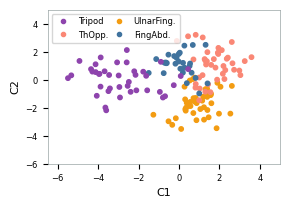

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig = plt.figure(figsize=(3,2))
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)


# construct cmap
flatui = [COLOR_DICT['wisteria'], COLOR_DICT['viz_orange'],  COLOR_DICT['orange'],COLOR_DICT['naval'],]
            #[COLOR_DICT['green_sea'], COLOR_DICT['viz_orange'],
            # COLOR_DICT['wisteria'], COLOR_DICT['naval']]

my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())



plt.set_cmap('Set3_r')
sp_names = ['Tripod', 'ThOpp.', 'UlnarFing.', 'FingAbd.']
scatter = plt.scatter(X_LDA_df.LDA1, 
            X_LDA_df.LDA2,
            s=10,
            c=X_LDA_df.gest_name.astype('category').cat.codes, alpha=1, cmap=my_cmap) 

plt.xlabel("C1", size=8)
plt.ylabel("C2", size=8)

# add legend to the plot with names
plt.legend(handles=scatter.legend_elements()[0], 
           labels=sp_names, ncol=2, fontsize=6, 
           loc='upper left',numpoints=1, markerscale=0.5, columnspacing=0.2)

plt.ylim([-6,5])
plt.xlim([-6.5,5])
plt.show()


# save fig
# fig.savefig(os.path.join(LDA_FIG, f'lda_2comp_tripod_open_bin_{bin_width}.png'), dpi=300, bbox_inches='tight')

In [278]:
# import seaborn as sns
# plt.figure(figsize=(4,2))
# # ax = fig.add_subplot(111)
# sns.lmplot('LDA1', 'LDA2', data=X_LDA_df, hue='gest_name', fit_reg=False)
# plt.show()